## Declare Global Variables

In [2]:
JOB_LIST = ["Software Architect", "Business Analyst", "Data Scientist", "Game Development",
            "Database Administrator", "Data Engineer", "Data Analysts","Software Engineer", "Web Development"]
DEFAULT_PATH = "/Users/nguyenvanviet/Work/Courses/My Thesis/PaperDataSet/"
COMPETENCIES_LIST = ["Knowledge", "Platform", "Framework", "ProgrammingLanguage", "Tool"]
WEB_LIST = ["Indeed", "CareerBuilder"]


## liberaries import

In [3]:
import pandas as pd
from neo4j import GraphDatabase
import sparknlp as sp
import csv


## Spark connection

In [4]:
spark = sp.start()

23/12/22 17:18:19 WARN Utils: Your hostname, MacBook-Air-cua-Nguyen-5.local resolves to a loopback address: 127.0.0.1; using 192.168.100.102 instead (on interface en0)
23/12/22 17:18:19 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


:: loading settings :: url = jar:file:/Users/nguyenvanviet/anaconda3/envs/spark2/lib/python3.9/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /Users/nguyenvanviet/.ivy2/cache
The jars for the packages stored in: /Users/nguyenvanviet/.ivy2/jars
com.johnsnowlabs.nlp#spark-nlp_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-989f583a-b3b4-4122-84b2-7ae90577adfd;1.0
	confs: [default]
	found com.johnsnowlabs.nlp#spark-nlp_2.12;5.2.0 in local-m2-cache
	found com.typesafe#config;1.4.2 in local-m2-cache
	found org.rocksdb#rocksdbjni;6.29.5 in local-m2-cache
	found com.amazonaws#aws-java-sdk-bundle;1.11.828 in local-m2-cache
	found com.github.universal-automata#liblevenshtein;3.0.0 in local-m2-cache
	found com.google.protobuf#protobuf-java-util;3.0.0-beta-3 in local-m2-cache
	found com.google.protobuf#protobuf-java;3.0.0-beta-3 in local-m2-cache
	found com.google.code.gson#gson;2.3 in local-m2-cache
	found it.unimi.dsi#fastutil;7.0.12 in local-m2-cache
	found org.projectlombok#lombok;1.16.8 in local-m2-cache
	found com.google.cloud#google-cloud-storage;2.20.1 in lo

## Neo4j connection

In [1]:

uri = "bolt://localhost:7690"  # Adjust the URI based on your Neo4j server configuration
username = "neo4j"
password = "12345678"

# Create a Neo4j driver instance
driver = GraphDatabase.driver(uri, auth=(username, password))
driver


NameError: name 'GraphDatabase' is not defined

## Neo4j query

In [6]:
def queryToCsv(query, fileName):

    columnName = fileName.lower()
    if fileName == "ProgrammingLanguage":
        columnName = "programmingLanguage" # programmingLanguage


    with driver.session() as session:
        result = session.run(query)
        data = [record['k'][columnName] for record in result]

    # Create a DataFrame with the transformed data
    df = pd.DataFrame(data, columns=[columnName])
        
    # Save DataFrame to a CSV file
    df.to_csv("Compentencies/" + fileName + ".csv", index=False, encoding="utf-8")
    print("Query results saved to ", fileName)

In [7]:
def queryToDataFrame(query, key):

    columnName = key.lower()
    if key == "ProgrammingLanguage":
        columnName = "programmingLanguage" # programmingLanguage


    with driver.session() as session:
        result = session.run(query)
        data = [record['k'][columnName] for record in result]


    # Create a DataFrame with the transformed data
    df = pd.DataFrame(data, columns=[columnName])

    return df[columnName].tolist()

def ListToSet(df):
    dataSet = set()
    for data in df:
        dataSet.add(data.strip())
    return dataSet




### Get all the existing compentencies

In [8]:
# queryToCsv("MATCH (k: Knowledge) RETURN k", "Knowledge")
# queryToCsv("MATCH (k: Platform) RETURN k", "Platform")
# queryToCsv("MATCH (k: ProgrammingLanguage) RETURN k", "ProgrammingLanguage") 
# queryToCsv("MATCH (k: Tool) RETURN k", "Tool")
# queryToCsv("MATCH (k: Framework) RETURN k", "Framework")

Competencies = {}

for comp in COMPETENCIES_LIST:
    query = "MATCH (k: " + comp + ") RETURN k"
    Competencies[comp] = ListToSet(queryToDataFrame(query, comp))

for comp in COMPETENCIES_LIST:
    print(Competencies[comp])

{'', 'computer vision', 'web technologies', 'network address translation', 'probability theory', 'object oriented', 'icd-10', 'ajax calls', 'data and network analytics', 'etl process', 'data pipeline', 'systems thinking', 'sql', 'gradient boosting', 'cybersecurity', 'data integration', 'web services', 'mapreduce', 'digital transformation', 'entity-relationship diagrams', 'Russian', 'self-hosting', 'ide', 'public health', 'decoder', 'finance', 'android mobile apps', 'design patterns', 'mode', 'prediction model', 'accountancy', 'linked list', 'definite integral', 'manual testing', 'principles of fairness', 'appropriate functions', 'descriptive analysis', 'backup strategies', 'software designs', 'non-parametric', 'spark structured streaming', 'deep learning', 'web-services', 'handle errors', 'shell scripting', 'data security', 'hdfs', 'algebra with inequalities', 'in-database analytics', 'cloud server', 'android security model', 'classification', 'graph-structured data', 'streaming video'

## Filtering competency in the requirement

In [9]:


def competencyDetect(requirement):
    res = []
    for comp in COMPETENCIES_LIST:
        temp = ""
        if len(Competencies[comp]) == 0: continue

        for ele in Competencies[comp]:
            idx = requirement.find(" " + ele + " ")
            idx2 = requirement.find(" " + ele.capitalize() + " ")
            idx3 = requirement.find(" " + ele.title() + " ")
            idx4 = requirement.find(" " + ele.title() + ",")
            idx5 = requirement.find(" " + ele.title() + ".")


            if idx != -1 or idx2 != -1 or idx3 != -1 or idx4 != -1 or idx5 != -1:
                temp += ele + ", " 
       
        if temp == "":
            temp = None
        else:
            temp = temp[:-2]
            temp += ""

        res.append(temp)
    
    return res


## Read all jobposting files

In [10]:
DataList = {}

for job in JOB_LIST:
    for web in WEB_LIST:
        df = spark.read.csv(DEFAULT_PATH + web + "/" + job + ".csv", header=True, inferSchema=True)
        DataList[web + "+" + job] = df



In [11]:

def toRow(data, compe, web, jobType):
    res = []
    res.append(data["companyName"])
    res.append(data["description"])
    res.append(data["jobName"])
    res.append(data["location"])
    res.append(data["require"])
    res.append(data["salary"])
    res.append(str(data["timePost"]))
    res.append(web)
    res.append(jobType)
    
    return res + compe
    

def dataToCsv(fileName):

    with open(fileName, 'w', newline='') as csvfile:
        csv_writer = csv.writer(csvfile)
        header = ["companyName", "description", "jobName", "location", "require", "salary", "timePost", "website", "jobType", "Knowledge", "Platform", "Framework", "ProgrammingLanguage", "Tool"]
        csv_writer.writerow(header)

        for job in JOB_LIST:
            for web in WEB_LIST:
                jobPost = DataList[web + "+" + job].toPandas()
                for _, row in jobPost.iterrows():
                    if row['require'] is None : continue
                    writedRow = toRow(row, competencyDetect(row['require']), web, job)
                    csv_writer.writerow(writedRow)
                print (job + " - " + web  + " - " +  "Done\n")
            

In [12]:
# Specify the file path
fileName = 'jobPost.csv'

# Writing to CSV file line by line
dataToCsv(fileName)

Software Architect - Indeed - Done

Software Architect - CareerBuilder - Done

Business Analyst - Indeed - Done

Business Analyst - CareerBuilder - Done

Data Scientist - Indeed - Done

Data Scientist - CareerBuilder - Done

Game Development - Indeed - Done

Game Development - CareerBuilder - Done

Database Administrator - Indeed - Done

Database Administrator - CareerBuilder - Done

Data Engineer - Indeed - Done

Data Engineer - CareerBuilder - Done

Data Analysts - Indeed - Done

Data Analysts - CareerBuilder - Done

Software Engineer - Indeed - Done

Software Engineer - CareerBuilder - Done

Web Development - Indeed - Done

Web Development - CareerBuilder - Done



## Checking area

In [13]:
import pandas as pd

df = pd.read_csv("jobPost.csv")
df.head(5)


,companyName,description,jobName,location,require,salary,timePost,website,jobType,Knowledge,Platform,Framework,ProgrammingLanguage,Tool
0,INTEL,"Job Description Architects, designs and provid...",Cloud Software Architect,"Santa Clara, CA","Job Description Architects, designs and provid...","$196,750 - $314,670 a year",2023-12-11,Indeed,Software Architect,"cloud computing, agile, business, logging, sec...","cloud, azure",database,azure,"cloud, cloud computing, agile, security, monit..."
1,Booz Allen Hamilton,"Job Description Location: Stafford,VA,US Remot...",Software-Solution Architect,"Remote in Stafford, VA","Job Description Location: Stafford,VA,US Remot...","$81,800 - $186,000 a year",2023-12-11,Indeed,Software Architect,"cloud computing, transform, health, business, ...",cloud,NaN,NaN,"cloud, cloud computing, transform, security, s..."
2,Salesforce,"To get the best candidate experience, please c...",Software Engineering Architect,"San Francisco, CA 94105 (Financial District/So...","To get the best candidate experience, please c...","$233,300 - $355,900 a year",2023-12-11,Indeed,Software Architect,", was, agile, business, programming, software ...",NaN,NaN,NaN,", agile, software development, performance, ba..."
3,INTEL,Job Description We are looking for a Senior So...,Development Tools Software Architect,"Phoenix, AZ",Job Description We are looking for a Senior So...,"$139,480 - $209,760 a year",2023-12-11,Indeed,Software Architect,", agile, relational, business, programming, so...",NaN,", unit","SQL, python, c#",", agile, relational, software development, uni..."
4,Salesforce,"To get the best candidate experience, please c...",Software Engineering Architect - Billing Systems,"Remote in San Francisco, CA 94105","To get the best candidate experience, please c...","$194,400 - $296,600 a year",2023-12-11,Indeed,Software Architect,", agile, business, software, distributed syste...",heroku,NaN,ruby,", maintenance, agile, distributed systems, per..."


In [14]:
df.groupby('jobType').describe()

companyName         \
                             count unique   
jobType                                     
Business Analyst               113     85   
Data Analysts                   70     59   
Data Engineer                   50     36   
Data Scientist                  51     35   
Database Administrator          75     55   
Game Development                79     51   
Software Architect              27     22   
Software Engineer              113     86   
Web Development                 59     53   

                                                                           \
                                                                 top freq   
jobType                                                                     
Business Analyst             VDSC - Công ty CP Chứng khoán Rồng Việt    4   
Data Analysts           Ngân Hàng TMCP Việt Nam Thịnh Vượng - VPBANK    4   
Data Engineer                                                     HP    4   
Data Scientist          Ngân Hàng TMCP Việt Nam Thịnh Vượng - VPBANK    9   
Database Administrator                                     Coca-Cola    6   
Game Development                                          Epic Games    8   
Software Architect                                        Salesforce    4   
Software Engineer                                Công Ty Cổ Phần VNG    7   
Web Development                               CÔNG TY TNHH TECHCRAFT    3   

                       description         \
                             count unique   
jobType                                     
Business Analyst               113    104   
Data Analysts                   70     67   
Data Engineer                   50     45   
Data Scientist                  51     46   
Database Administrator          75     71   
Game Development                79     67   
Software Architect              27     27   
Software Engineer              113    108   
Web Development                 59     56   

                                                                           \
                                                                      top   
jobType                                                                     
Business Analyst        Mô tả Công việc PURPOSE AND SCOPE The Head of ...   
Data Analysts           We are currently looking for multiple outstand...   
Data Engineer           We are looking for a Data Engineer to join our...   
Data Scientist          Mô tả Công việc VPBank hiện là một trong những...   
Database Administrator                                            nothing   
Game Development        Department Audio & Design Location Cary North ...   
Software Architect      Job Description Architects, designs and provid...   
Software Engineer       Mô tả Công việc - Xây dựng và triển khai các p...   
Web Development         Are you ready to be a key contributor to our b...   

                            jobName         ...                 Framework  \
                       freq   count unique  ...                       top   
jobType                                     ...                             
Business Analyst          2     113     97  ...                     excel   
Data Analysts             2      70     59  ...                     excel   
Data Engineer             3      50     23  ...                  database   
Data Scientist            3      51     30  ...                  r, excel   
Database Administrator    3      75     67  ...                  database   
Game Development          4      79     64  ...     unreal engine, unreal   
Software Architect        1      27     20  ...                  database   
Software Engineer         2     113     98  ...                  database   
Web Development           2      59     53  ...  unit, angular, bootstrap   

                            ProgrammingLanguage                            \
                       freq               count unique           top freq   
jobType     

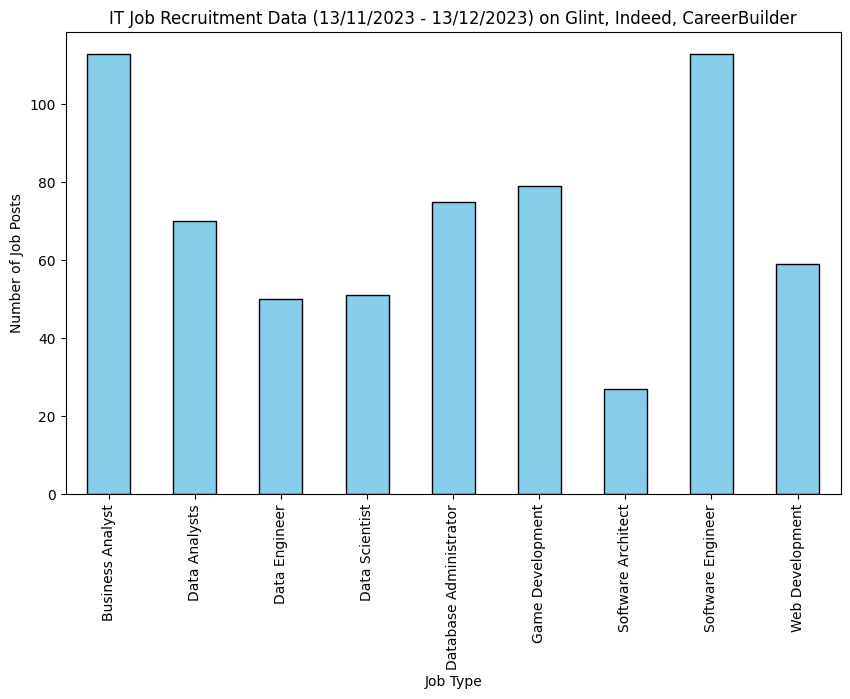

In [15]:
df['jobType'].value_counts()

import matplotlib.pyplot as plt

# Assuming df is your DataFrame containing 'jobType' column
# Group by 'jobType' and calculate the count of rows for each group
grouped_df = df.groupby('jobType').size()

# Plotting the bar chart
grouped_df.plot(kind='bar', color='skyblue', edgecolor='black', figsize=(10, 6))

# Adding labels and title
plt.xlabel('Job Type')
plt.ylabel('Number of Job Posts')
plt.title('IT Job Recruitment Data (13/11/2023 - 13/12/2023) on Glint, Indeed, CareerBuilder')

# Show the plot
plt.show()



In [16]:

def toRow(data, compe, web, jobType):
    s = '
    s += data["companyName"] + "," +\
        data["description"] + "," +\
        data["jobName"] + "," +\
        data["location"] + "," +\
        data["require"] + "," +\
        data["salary"] + "," +\
        data["timePost"] + "," +\
        web + "," +\
        jobType + "," +\
        compe
    
    return s

def dataToCsv(fileName):

    with open(fileName, 'w', newline='') as csvfile:
        csv_writer = csv.writer(csvfile)
        header = "companyName,description,jobName,location,require,salary,timePost,website,jobType,Knowledge,Platform,Framework,ProgrammingLanguage,Tool"
        csv_writer.writerow()

        for job in JOB_LIST:
            for web in WEB_LIST:
                jobPost = DataList[web + "+" + job].toPandas()
                for idx in jobPost:
                    print(toRow(idx, ))
                    #csv_writer.writerow(row)

In [17]:
len(df)

637

## Testing area

In [18]:
desc = "Are you a Business Analyst who wants to help make a difference conceptualizing the business needs for MilitaryChildcare.com and telework 100%? Then we have a great opportunity for you! As a Business Analyst you will: Work with a team of driven, supportive, and highly skilled professionals. Receive a robust benefits package that includes our Employee Stock Ownership Plan! (ESOP). Enjoy flexibility managing your work hours and personal needs with a single accrual leave plan. A week in the life of a Business Analyst: Translate high-level business needs into detailed requirements for new capabilities and enhancements to existing capabilities. Write comprehensive requirement documents resulting in a detailed and complete understanding of project deliverables. Work with customers, software engineers, architects, and other team members to capture business needs and drive quality solutions. Participate in system design and review test cases to ensure requirements are being met and addresses all impacted areas of the system. Perform functional validation to ensure the system aligns with requirements. Create wireframes and workflows using Figma, SnagIt, Excel, and Visio. Adhere to compliance standards and ensure all necessary approvals have been obtained throughout the project lifecycle. Support Tier 2 Support Desk working with Tier 1 Support Desk and technical team to triage issues and communicate timelines and status. Provide input to Weekly and Monthly Status Report(s). Other Business Analyst Team duties as required Job Requirements Bachelor’s degree 5 - 7 years of related experience US Citizenship required Understanding of analysis techniques Familiarity with Agile development methodology Experience with Figma, SnagIt, Microsoft Office tools, Visio Founded in 1975, AMERICAN SYSTEMS is one of the largest employee-owned companies in the United States. We are a government services contractor focused on delivering Strategic Solutions to complex national priority programs with 100+ locations worldwide. Through our focus on quality, strong cultural beliefs, and innovation we deliver excellence every day. Company Awards: Forbes National Best Midsize Companies Energage National Best Workplaces, National Washington Post Best Workplaces Veteran Hiring Awards: U.S. Department of Labor Hire Vets Medallion BEST FOR VETS by Military Times TOP 10 MILITARY FRIENDLY COMPANY by MilitaryFriendly.com AMERICAN SYSTEMS is committed to pay transparency for our applicants and employee-owners. The salary range for this position is $70,000 – 90,000. Actual compensation will be determined based on several factors permitted by law. AMERICAN SYSTEMS provides for the welfare of its employees and their dependents through a comprehensive benefits program by offering healthcare benefits, paid leave, retirement plans (including ESOP and 401k), insurance programs, and education and training assistance. EOE Minorities/Women/Disabled/Veterans/Gender Identity/Sexual Orientation"
test2 = "MathWorks has a hybrid work model that enables staff members to split their time between office and home. The hybrid model provides the advantage of having both in-person time with colleagues and flexible at-home life optimizations. Learn More: https://www.mathworks.com/company/jobs/resources/applying-and-interviewing.html#onboarding. Working under the direction of the Manager or Senior Team Lead, will be responsible for designing and developing sophisticated software for small self-contained projects; designing and implementing moderately-complex software features and components of control systems software; writing high quality code; designing extensible software using software engineering principles, patterns and methodologies; executing performance monitoring and integration; participating in software development projects of moderate scope, from requirements gathering and design to implementation, qualification and validation; assisting cross-functional team members in engineering, quality engineering, user experience, and documentation; increasing productivity and bringing quality features to market; and working with subject matter experts in pursuit of continuous improvement of designs and strategies. MathWorks nurtures growth, appreciates diversity, encourages initiative, values teamwork, shares success, and rewards excellence. Minimum Qualifications: Education and Experience: Master’s degree in Engineering, Computer Science, or a closely related field (or foreign education equivalent) and no experience. OR Bachelor’s degree in Engineering, Computer Science, or a closely related field (or foreign education equivalent) and three (3) years of experience as a Software Engineer (or related occupation) performing development, testing or technical support of control design automation toolboxes. Special Requirements: Demonstrated expertise in development, testing or technical support of controls-based simulation software. Demonstrated expertise in object-oriented design and analysis, including writing algorithms, applying design patterns, and programming in C++ and MATLAB or Simulink. Demonstrated expertise writing algorithms and data structures using modern C++ standard libraries - smart pointers, move semantics, templates and lambda functions - and using C++ Standard Template Library for code optimization. Demonstrated expertise in the full software development life cycle (SDLC), including functional design, architecture design, implementation, and testing, according to scrum-based Agile methodologies. [Expertise may be gained during Graduate program.]"
print (competencyDetect(desc))
print (competencyDetect(test2))

['agile, business, functional, software, analysis, government, compliance, healthcare, insurance, factors', None, 'excel', None, 'agile, analysis, Excel, compliance, excel, agile development, a']
['agile, programming, computer science, software development, functional, algorithms, data structures, software, functions, object-oriented, testing, performance', None, None, 'c++', 'requirements gathering, agile, software development life cycle, software development, data structures, monitoring, testing, performance, a']


## Course recommendations

In [19]:
def toCondition(entity, attr, listCondi):
    conditions = []
    
    # Split the listCondi string into individual keywords
    keywords = [keyword.strip() for keyword in listCondi.split(',')]

    # Create conditions for each keyword
    for keyword in keywords:
        condition = f"{entity}{attr} = '{keyword}'"
        conditions.append(condition)

    # Join the conditions with 'OR'
    condition_string = ' OR '.join(conditions)

    return condition_string

def toConditionInside(attr, listCondi):
    conditions = []
    
    # Split the listCondi string into individual keywords
    keywords = [keyword.strip() for keyword in listCondi.split(',')]

    # Create conditions for each keyword
    for keyword in keywords:
        condition = f"{attr}: '{keyword}'"
        conditions.append(condition)

    # Join the conditions with 'OR'
    condition_string = ' OR '.join(conditions)

    return condition_string

def toAndCondition(entity, attr, listCondi):
    conditions = []
    
    # Split the listCondi string into individual keywords
    keywords = [keyword.strip() for keyword in listCondi.split(',')]

    # Create conditions for each keyword
    for keyword in keywords:
        condition = f"{entity}.{attr} = '{keyword}'"
        conditions.append(condition)

    # Join the conditions with 'OR'
    condition_string = ' AND '.join(conditions)

    return condition_string

**Ultimate Condition**
- And all the conditions

**Good Condition**
- or condtion in each compen
- and all the conditions

**Conditions**
- or conditions in each compen
- and programming language and framework


**Optional Condition**
- Or all the conditions

In [20]:
desc3 = "SKILL AND EXPERIENCE 2 years of experience in similar roles. Experience with SQL Databases, particularly Oracle and PostgreSQL (PostgreSQL is a plus). Proficiency in Python, Airflow, Docker, MinIO, Crawler libraries, Data Dictionary Platforms, etc. Strong analytical skills, logical thinking, problem-solving abilities, and effective communication. Adaptability with various programming languages. Nice to have experience with OTP/Captcha. Familiarity with encryption algorithms and hash codes such as SHA256. Additional experience with Java, JavaScript, Spark, Kafka, RabbitMQ is a plus. Strong data analysis skills and the ability to derive meaningful insights from data. Capacity to work well under high-pressure conditions. Demonstrated teamwork, independence, a can-do attitude, and self-study skills."
competen = competencyDetect(desc3)

knowledge = competen[0]
platform = competen[1]
framework = competen[2]
programmingLanguage = competen[3]
tool = competen[4]

KLattr = "knowledge"
LVattr = "level"
TLattr = "tool"
PFattr = "platform"
PLattr = "programmingLanguage"
FWattr = "framework"

kl = "kl."
lv = "lv."
tl = "tl."
pl = "pl."
pf = "pf."
fw = "fw."



def ultimateCondition():
    ultimateKL = toAndCondition(kl, KLattr, knowledge)
    ultimateTL = toAndCondition(tl, TLattr, tool)
    ultimatePF = toAndCondition(pf, PFattr, platform)
    ulitmatePL = toAndCondition(pl, PLattr, programmingLanguage)
    ulitmateFW = toAndCondition(fw, FWattr, framework)
    return ultimateKL + " AND " + ulitmatePL + " AND " + ulitmateFW + " AND " + ultimatePF + " AND " + ultimateTL 

def goodCondition():
    ultimateKL = toCondition(kl, KLattr, knowledge)
    ultimateTL = toCondition(tl, TLattr, tool)
    ultimatePF = toCondition(pf, PFattr, platform)
    ulitmatePL = toCondition(pl, PLattr, programmingLanguage)
    ulitmateFW = toCondition(fw, FWattr, framework)
    return "(" + ultimateKL + ") AND (" + ulitmatePL + ") AND (" + ulitmateFW + ") AND (" + ultimatePF + ") AND (" + ultimateTL + ")"

def condition():
    ultimateKL = toCondition(kl, KLattr, knowledge)
    ulitmatePL = toCondition(pl, PLattr, programmingLanguage)
    ulitmateFW = toCondition(fw, FWattr, framework)
    return "(" + ultimateKL + ") AND (" + ulitmatePL + ") AND (" + ulitmateFW + ")"

def optionalCondition():
    ultimateKL = toCondition(kl, KLattr, knowledge)
    ultimateTL = toCondition(tl, TLattr, tool)
    ultimatePF = toCondition(pf, PFattr, platform)
    ulitmatePL = toCondition(pl, PLattr, programmingLanguage)
    ulitmateFW = toCondition(fw, FWattr, framework)
    return "(" + ultimateKL + ") OR (" + ulitmatePL + ") OR (" + ulitmateFW + ") OR (" + ultimatePF + ") OR (" + ultimateTL + ")"


    
print("Compentencies:")
print(" - Knowledge: " + knowledge)
print(" - Programming Language: " + programmingLanguage)
print(" - Framework: " + framework)
print(" - Platform: " + platform)
print(" - Tool: " + tool)






Compentencies:
 - Knowledge: programming, algorithms, analysis, databases, spark, data analysis
 - Programming Language: docker, kafka, java, SQL, python, spark
 - Framework: spark, data analysis
 - Platform: airflow, kafka, spark, data analysis
 - Tool: analysis, oracle, databases, a, data analysis


In [21]:
def fomatedString(sign, attr, st):
    if len(st) < 1: return ''
    formatted_string = '[' + ', '.join(f"'{item.strip()}'" for item in st.split(',')) + ']'
    return sign  + attr + " IN " + formatted_string


In [22]:
query = "MATCH (course:FactCourse) \
    OPTIONAL MATCH (course)-[:TEACH_KNOWLEDGE]->(kl:Knowledge) \
    OPTIONAL MATCH (course)-[:TEACH_TOOL]->(tl:Tool) \
    OPTIONAL MATCH (course)-[:TEACH_FRAMEWORK]->(fw:Framework) \
    OPTIONAL MATCH (course)-[:TEACH_PLATFORM]->(pf:Platform) \
    OPTIONAL MATCH (course)-[:TEACH_PROGRAMMING_LANGUAGE]->(pl:ProgrammingLanguage) \
    OPTIONAL MATCH (course)-[:BELONG_TO_COURSE]->(rc:Course) "

queryExt = "MATCH (course:FactCourse) \
    OPTIONAL MATCH (course:FactCourse)-[:TEACH_KNOWLEDGE]->(kl:Knowledge) \
    OPTIONAL MATCH (course:FactCourse)-[:TEACH_TOOL]->(tl:Tool) \
    OPTIONAL MATCH (course:FactCourse)-[:TEACH_FRAMEWORK]->(fw:Framework) \
    OPTIONAL MATCH (course:FactCourse)-[:TEACH_PLATFORM]->(pf:Platform) \
    OPTIONAL MATCH (course:FactCourse)-[:TEACH_PROGRAMMING_LANGUAGE]->(pl:ProgrammingLanguage) \
    OPTIONAL MATCH (course:FactCourse)-[:BELONG_TO_COURSE]->(rc:Course) "

query2 = "MATCH (course:FactCourse) \
    OPTIONAL MATCH (course)-[:TEACH_KNOWLEDGE]->(kl:Knowledge) \
    OPTIONAL MATCH (course)-[:TEACH_FRAMEWORK]->(fw:Framework) \
    OPTIONAL MATCH (course)-[:TEACH_PROGRAMMING_LANGUAGE]->(pl:ProgrammingLanguage) \
    OPTIONAL MATCH (course)-[:BELONG_TO_COURSE]->(rc:Course) "


optionalQuery = "MATCH (rc1:Course) <-[:BELONG_TO_COURSE] - (course2:FactCourse)-[:TEACH_KNOWLEDGE]->(kl:Knowledge) \
    OPTIONAL MATCH (rc2:Course) <-[:BELONG_TO_COURSE] - (course3:FactCourse)-[:TEACH_TOOL]->(tl:Tool) \
    OPTIONAL MATCH (rc3:Course) <-[:BELONG_TO_COURSE] - (course4:FactCourse)-[:TEACH_FRAMEWORK]->(fw:Framework) \
    OPTIONAL MATCH (rc4:Course) <-[:BELONG_TO_COURSE] - (course5:FactCourse)-[:TEACH_PLATFORM]->(pf:Platform) \
    OPTIONAL MATCH (rc5:Course) <-[:BELONG_TO_COURSE] - (course6:FactCourse)-[:TEACH_PROGRAMMING_LANGUAGE]->(pl:ProgrammingLanguage)"

langQuery = "MATCH (pl:ProgrammingLanguage)- [:HAVE_FRAMEWORK] -> (fw:Framework) \
    OPTIONAL MATCH (pl)-[:RELATED_TO_PL]->(kl:Knowledge) \
    OPTIONAL MATCH (pl)-[:HAVE_FRAMEWORK]->(fw:Framework) \
    OPTIONAL MATCH (pl)-[:USE_FOR]->(tl:Tool) \
    OPTIONAL MATCH (pl)-[:TEACH_PROGRAMMING_LANGUAGE]->(rc:Course)"

# (rc:Course) <-[:BELONG_TO_COURSE] - 
returnQuery = "return rc, tl, fw,pl,kl,pf"

returnQuery2 = "return rc, fw ,pl,kl"

returnCourse = "return rc1, rc2, rc3, rc4, rc5"



In [23]:
def queryToList(query):
    with driver.session() as session:
        result = session.run(query)            
        if (len(result.data()) > 0): 
            result_list = [record for record in result.data()]
            print("here we go again")
            print(result.data())
        

    return result_list

def queryNeo4j(query):
    with driver.session() as session:
        result = session.run(query)

        # Convert result to DataFrame
        columns = result.keys()
        data = [record.values() for record in result]
        df = pd.DataFrame(data, columns=columns)

    return df



In [ ]:
for prolang in [keyword.strip() for keyword in programmingLanguage.split(',')]:
    langQuery = f"MATCH (pl:ProgrammingLanguage {{ programmingLanguage: '{prolang}'}})- [:HAVE_FRAMEWORK] -> (fw:Framework ) \
    OPTIONAL MATCH (pl)-[:RELATED_TO_PL]->(kl:Knowledge ) \
    OPTIONAL MATCH (pl)-[:USE_FOR]->(tl:Tool) \
    OPTIONAL MATCH (pl)<-[:TEACH_PROGRAMMING_LANGUAGE]-(c:FactCourse)-[:BELONG_TO_COURSE]->(rc:Course)\
    where  {fomatedString(fw, FWattr, framework)} AND  {fomatedString(tl, TLattr, tool)} AND {fomatedString(kl, KLattr, knowledge)}\
    return rc, pl, fw, kl, tl"
    # print(langQuery)
    # print(queryToList(langQuery))

for prolang in programmingLanguage.split(','):
    queryExt = F"MATCH (course:FactCourse)-[:TEACH_KNOWLEDGE]->(kl:Knowledge) \
        OPTIONAL MATCH (course:FactCourse)-[:TEACH_TOOL]->(tl:Tool) \
        OPTIONAL MATCH (course:FactCourse)-[:TEACH_FRAMEWORK]->(fw:Framework) \
        OPTIONAL MATCH (course:FactCourse)-[:TEACH_PLATFORM]->(pf:Platform) \
        OPTIONAL MATCH (course:FactCourse)-[:TEACH_PROGRAMMING_LANGUAGE]->(pl:ProgrammingLanguage) \
        OPTIONAL MATCH (course:FactCourse)-[:BELONG_TO_COURSE]->(rc:Course) \
        where  {fomatedString(pl, PLattr, programmingLanguage)} AND {fomatedString(fw, FWattr, framework)} AND  {fomatedString(tl, TLattr, tool)}\
        AND {fomatedString(kl, KLattr, knowledge)} AND {fomatedString(pf, PFattr, platform)}\
        return rc, pl, fw, kl, tl, pf"
    print(queryToList(langQuery))


    



In [24]:

queryExt = F"MATCH (course:FactCourse)-[:TEACH_KNOWLEDGE]->(kl:Knowledge) \
    OPTIONAL MATCH (course:FactCourse)-[:TEACH_TOOL]->(tl:Tool) \
    OPTIONAL MATCH (course:FactCourse)-[:TEACH_FRAMEWORK]->(fw:Framework) \
    OPTIONAL MATCH (course:FactCourse)-[:TEACH_PLATFORM]->(pf:Platform) \
    OPTIONAL MATCH (course:FactCourse)-[:TEACH_PROGRAMMING_LANGUAGE]->(pl:ProgrammingLanguage) \
    OPTIONAL MATCH (course:FactCourse)-[:BELONG_TO_COURSE]->(rc:Course) \
    where  {fomatedString(pl, PLattr, programmingLanguage)} OR {fomatedString(fw, FWattr, framework)} OR  {fomatedString(tl, TLattr, tool)}\
    OR {fomatedString(kl, KLattr, knowledge)} OR {fomatedString(pf, PFattr, platform)}\
    return rc, pl, fw, kl, tl, pf"
print(queryToList(queryExt))

here we go again
[]
[]


MATCH (pl:ProgrammingLanguage) where  pl.programmingLanguage IN ['docker', 'java', 'SQL', 'python', 'kafka', 'spark']    OPTIONAL MATCH (rc:Course)<-[:BELONG_TO_COURSE]-(course:FactCourse)-[:TEACH_PROGRAMMING_LANGUAGE]-> (pl)    
OPTIONAL MATCH (kl:Knowledge) where  kl.knowledge IN ['analysis', 'data analysis', 'programming', 'spark', 'algorithms', 'databases']    OPTIONAL MATCH (course)-[:TEACH_KNOWLEDGE]-> (kl)    
OPTIONALMATCH (fw:Framework) where  fw.framework IN ['spark', 'data analysis']    OPTIONAL MATCH (course)-[:TEACH_FRAMEWORK]-> (fw)    return  kl.knowledge, fw.framework, rc.name, rc.link, rc.enroll order by rc.enroll desc


In [59]:
queryProMax = f"MATCH (pl:ProgrammingLanguage) where  {fomatedString(pl, PLattr, programmingLanguage)}\
    OPTIONAL MATCH (rc:Course)<-[:BELONG_TO_COURSE]-(course:FactCourse)-[:TEACH_PROGRAMMING_LANGUAGE]-> (pl)\
    OPTIONAL MATCH (kl:Knowledge) where  {fomatedString(kl, KLattr, knowledge)}\
    OPTIONAL MATCH (course)-[:TEACH_KNOWLEDGE]-> (kl)\
    OPTIONAL MATCH (fw:Framework) where  {fomatedString(fw, FWattr, framework)}\
    OPTIONAL MATCH (course)-[:TEACH_FRAMEWORK]-> (fw)\
    return  rc.name as `Course Name`,\
        pl.programmingLanguage as `Programming Language`,  COLLECT(DISTINCT fw.framework) as Framework ,  COLLECT(DISTINCT kl.knowledge) as Knowledge,\
        rc.link as `Course Link`,\
        rc.enroll as Enroll order by rc.enroll desc"
print("Recommendation Language Learning Courses: ")
df = queryNeo4j(queryProMax)
df = df.dropna(subset=['Course Name'])

pd.set_option('display.colheader_justify', 'center')


# Apply formatting to the DataFrame for text alignment and background color
styled_df = df.head(5).reset_index(drop=True).style.set_table_styles([
    {'selector': 'th', 'props': [('text-align', 'center')]},
    {'selector': 'td', 'props': [('text-align', 'left')]},
    {'selector': 'table', 'props': [('background-color', 'lightgray')]}
])

# Print the formatted DataFrame using head()
styled_df



Recommendation Language Learning Courses: 


,Course Name,Programming Language,Framework,Knowledge,Course Link,Enroll
0,Introduction to Data Science in Python,python,"['data analysis', 'spark']","['programming', 'data analysis', 'databases', 'algorithms', 'analysis', 'spark']",https://www.coursera.org/learn/python-data-analysis,634691.000000
1,Free Android Development Tutorial - Become an Android Developer from Scratch,java,"['data analysis', 'spark']","['programming', 'data analysis', 'databases', 'algorithms', 'analysis', 'spark']",https://www.udemy.com/course/become-an-android-developer-from-scratch/,575261.000000
2,Using Python to Access Web Data,python,"['data analysis', 'spark']","['programming', 'data analysis', 'databases', 'algorithms', 'analysis', 'spark']",https://www.coursera.org/learn/python-network-data,529528.000000
3,Using Databases with Python,python,"['data analysis', 'spark']","['programming', 'data analysis', 'databases', 'algorithms', 'analysis', 'spark']",https://www.coursera.org/learn/python-databases,396073.000000
4,"Python for Data Science, AI & Development",python,"['data analysis', 'spark']","['programming', 'data analysis', 'databases', 'algorithms', 'analysis', 'spark']",https://www.coursera.org/learn/python-for-applied-data-science-ai,348943.000000


In [78]:
queryUltraProMax =  f"MATCH (pl:ProgrammingLanguage) where  {fomatedString(pl, PLattr, programmingLanguage)}\
    OPTIONAL MATCH (rc:Course)<-[:BELONG_TO_COURSE]-(course:FactCourse)-[:TEACH_PROGRAMMING_LANGUAGE]-> (pl)\
    OPTIONAL MATCH (kl:Knowledge) where  {fomatedString(kl, KLattr, knowledge)}\
    OPTIONAL MATCH (course)-[:TEACH_KNOWLEDGE]-> (kl)\
    OPTIONAL MATCH (fw:Framework) where  {fomatedString(fw, FWattr, framework)}\
    OPTIONAL MATCH (course)-[:TEACH_FRAMEWORK]-> (fw)\
    OPTIONAL MATCH (pf:Platform) where  {fomatedString(pl, PLattr, platform)}\
    OPTIONAL MATCH (course)-[:TEACH_FRAMEWORK]-> (pf)\
    OPTIONAL MATCH (tl:Tool) where  {fomatedString(tl, TLattr, tool)}\
    OPTIONAL MATCH (course)-[:TEACH_FRAMEWORK]-> (tl)\
    return  rc.name as `Course Name`,\
        pl.programmingLanguage as `Programming Language`,  COLLECT(DISTINCT fw.framework) as Framework ,  COLLECT(DISTINCT kl.knowledge) as Knowledge,\
        COLLECT(DISTINCT pf.platform) as Platform ,  COLLECT(DISTINCT tl.tool) as Tool,\
        rc.link as `Course Link`,\
        toInteger(rc.enroll) as Enroll order by Enroll desc"
print("Highly Recommendation Language Learning Courses: ")
df = queryNeo4j(queryUltraProMax)
df = df.dropna(subset=['Course Name'])


# Apply formatting to the DataFrame for text alignment and background color
styled_df = df.head(5).reset_index(drop=True).style.set_table_styles([
    {'selector': 'th', 'props': [('text-align', 'center')]},
    {'selector': 'td', 'props': [('text-align', 'left')]},
    {'selector': 'table', 'props': [('background-color', 'lightgray')]}
])
styled_df.format({'Enroll': '{:,.0f}'.format})
# Print the formatted DataFrame using head()
styled_df


Highly Recommendation Language Learning Courses: 


,Course Name,Programming Language,Framework,Knowledge,Platform,Tool,Course Link,Enroll
0,Introduction to Data Science in Python,python,"['data analysis', 'spark']","['programming', 'data analysis', 'databases', 'algorithms', 'analysis', 'spark']",[],"['data analysis', 'analysis', 'oracle', 'a']",https://www.coursera.org/learn/python-data-analysis,"634,691"
1,Free Android Development Tutorial - Become an Android Developer from Scratch,java,"['data analysis', 'spark']","['programming', 'data analysis', 'databases', 'algorithms', 'analysis', 'spark']",[],"['data analysis', 'analysis', 'oracle', 'a']",https://www.udemy.com/course/become-an-android-developer-from-scratch/,"575,261"
2,Using Python to Access Web Data,python,"['data analysis', 'spark']","['programming', 'data analysis', 'databases', 'algorithms', 'analysis', 'spark']",[],"['data analysis', 'analysis', 'oracle', 'a']",https://www.coursera.org/learn/python-network-data,"529,528"
3,Using Databases with Python,python,"['data analysis', 'spark']","['programming', 'data analysis', 'databases', 'algorithms', 'analysis', 'spark']",[],"['data analysis', 'analysis', 'oracle', 'a']",https://www.coursera.org/learn/python-databases,"396,073"
4,"Python for Data Science, AI & Development",python,"['data analysis', 'spark']","['programming', 'data analysis', 'databases', 'algorithms', 'analysis', 'spark']",[],"['data analysis', 'analysis', 'oracle', 'a']",https://www.coursera.org/learn/python-for-applied-data-science-ai,"348,943"


## optional course areas

In [83]:
queryExt = F"MATCH (course:FactCourse)-[:TEACH_KNOWLEDGE]->(kl:Knowledge) \
    OPTIONAL MATCH (course:FactCourse)-[:TEACH_TOOL]->(tl:Tool) \
    OPTIONAL MATCH (course:FactCourse)-[:TEACH_FRAMEWORK]->(fw:Framework) \
    OPTIONAL MATCH (course:FactCourse)-[:TEACH_PLATFORM]->(pf:Platform) \
    OPTIONAL MATCH (course:FactCourse)-[:TEACH_PROGRAMMING_LANGUAGE]->(pl:ProgrammingLanguage) \
    OPTIONAL MATCH (course:FactCourse)-[:BELONG_TO_COURSE]->(rc:Course) \
    where  {fomatedString(pl, PLattr, programmingLanguage)} \
    return rc.name, pl.programmingLanguage"

query2 = f"MATCH (pl:ProgrammingLanguage) where  {fomatedString(pl, PLattr, programmingLanguage)}\
    OPTIONAL MATCH (rc:Course)<-[:BELONG_TO_COURSE]-(course:FactCourse)-[:TEACH_PROGRAMMING_LANGUAGE]-> (pl)\
    return  rc.name as `Course Name`,\
        pl.programmingLanguage as `Programming Language`, \
        rc.link as `Course Link`,\
        rc.enroll as Enroll order by rc.enroll desc"
print("Optional Programming Language Learning Courses: ")
df = queryNeo4j(query2)
df = df.dropna(subset=['Course Name'])
# Apply formatting to the DataFrame for text alignment and background color
styled_df = df.iloc[4:9].reset_index(drop=True).style.set_table_styles([
    {'selector': 'th', 'props': [('text-align', 'center')]},
    {'selector': 'td', 'props': [('text-align', 'left')]},
    {'selector': 'table', 'props': [('background-color', 'lightgray')]}
])
styled_df.format({'Enroll': '{:,.0f}'.format})
# Print the formatted DataFrame using head()
styled_df

Optional Programming Language Learning Courses: 


,Course Name,Programming Language,Course Link,Enroll
0,"Python for Data Science, AI & Development",python,https://www.coursera.org/learn/python-for-applied-data-science-ai,"348,943"
1,Databases and SQL for Data Science with Python,python,https://www.coursera.org/learn/sql-data-science,"220,195"
2,Data Analysis with Python,python,https://www.coursera.org/learn/data-analysis-with-python,"213,336"
3,Data Structures,python,https://www.coursera.org/learn/data-structures,"205,479"
4,"Java Programming: Arrays, Lists, and Structured Data",java,https://www.coursera.org/learn/java-programming-arrays-lists-data,"124,477"


In [84]:
query2 = f"MATCH (kl:Knowledge) where  {fomatedString(kl, KLattr, knowledge)}\
    OPTIONAL MATCH (rc:Course)<-[:BELONG_TO_COURSE]-(course:FactCourse)-[:TEACH_KNOWLEDGE]-> (kl)\
    return  rc.name as `Course Name`, {kl}{KLattr} as Knowledge, rc.link as `Course Link`, rc.enroll as Enroll order by rc.enroll desc"
print("Optional Knowledge Learning Courses: ")
df = queryNeo4j(query2)
df = df.dropna(subset=['Course Name'])
# Apply formatting to the DataFrame for text alignment and background color
styled_df = df.head(5).reset_index(drop=True).style.set_table_styles([
    {'selector': 'th', 'props': [('text-align', 'center')]},
    {'selector': 'td', 'props': [('text-align', 'left')]},
    {'selector': 'table', 'props': [('background-color', 'lightgray')]}
])
styled_df.format({'Enroll': '{:,.0f}'.format})
# Print the formatted DataFrame using head()
styled_df

Optional Knowledge Learning Courses: 


,Course Name,Knowledge,Course Link,Enroll
0,Data Science Math Skills,data analysis,https://www.coursera.org/learn/datasciencemathskills,"289,819"
1,Google Cloud Big Data and Machine Learning Fundamentals,data analysis,https://www.coursera.org/learn/gcp-big-data-ml-fundamentals,"228,702"
2,Introduction to Data Analysis Using Excel,data analysis,https://www.coursera.org/learn/excel-data-analysis,"209,592"
3,Prepare Data for Exploration,databases,https://www.coursera.org/learn/data-preparation,"119,518"
4,Big Data Analysis with Scala and Spark,data analysis,https://www.coursera.org/learn/scala-spark-big-data,"90,075"


In [ ]:
query2 = f"MATCH (fw:Framework) where  {fomatedString(fw, FWattr, framework)}\
    OPTIONAL MATCH (rc:Course)<-[:BELONG_TO_COURSE]-(course:FactCourse)-[:TEACH_FRAMEWORK]-> (fw)\
    return  {fw}{FWattr}, rc.name, rc.link, rc.enroll order by rc.enroll desc"

print(query2)
# print("Optional Framework Learning Courses: ")
# df = queryNeo4j(query2)
# df = df.dropna(subset=['rc.name'])
# df.head(5)

MATCH (fw:Framework) where  fw.framework IN ['spark', 'data analysis']    OPTIONAL MATCH (rc:Course)<-[:BELONG_TO_COURSE]-(course:FactCourse)-[:TEACH_FRAMEWORK]-> (fw)    return  fw.framework, rc.name, rc.link, rc.enroll order by rc.enroll desc


MATCH (pl:ProgrammingLanguage) where  pl.programmingLanguage IN ['docker', 'java', 'SQL', 'python', 'kafka', 'spark'] 
OPTIONAL MATCH (rc:Course)<-[:BELONG_TO_COURSE]-(course:FactCourse)-[:TEACH_PROGRAMMING_LANGUAGE]-> (pl)
return  pl, rc, course

In [ ]:
ultimateQuery = query + " where " + ultimateCondition() + returnQuery
print(ultimateQuery)
queryToList(ultimateQuery)


In [ ]:
ultimateQuery = query2 + " where " + condition() + returnQuery2
print(ultimateQuery)
queryToList(ultimateQuery)


In [ ]:
ultimateQuery = query + " where " + condition() + returnQuery
print(ultimateQuery)
queryToList(ultimateQuery)

In [ ]:
ultimateQuery = optionalQuery + " where " + optionalCondition() + returnCourse
print(ultimateQuery)
queryToList(ultimateQuery)

In [ ]:

condition = toCondition("job",attr, listCondi)
print(condition)